# Measurement

We support the following measurements:

- spectroscopy
- lifetime
- Rabi oscillation

In [9]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pydatatom import *

%matplotlib ipympl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Spectroscopy

Here we analyze two datasets where we scan the resonance of

- the clock transition $\ket{1{}^1S_0}\to\ket{1{}^3P_0}$, and
- the rydberg transition $\ket{1{}^3P_0}\to\ket{53.3{}^1S_0}$

In [45]:
raw_dataset_clk = GzipPickleDataset("/tmp/data/2025-08-05_AA")
raw_dataset_ryd = GzipPickleDataset("/tmp/data/2025-08-05_AO")

prob_pipeline_spec = Pipeline(steps=[
    TransformStep(PickKey("image")),
    ImageMeanStep(),
    AtomCropStep(atom_num=16),
    AtomCountStep(),
    AtomStatsStep(),
])
prob_pipeline_spec.fit(raw_dataset_clk)

In [46]:
def dataframe_from(raw_dataset, prop_pipeline):
    prob_dataset = prob_pipeline.transform(raw_dataset)

    prob_df = Transform(prob_dataset, [
        lambda p: { "probability": p.tolist() }
    ]).to_pandas()
    meta_df = Transform(raw_dataset, [
        PickType(float),
    ]).to_pandas()

    df = pd.concat([meta_df, prob_df], axis=1)
    df = df.dropna()
    df = df.loc[:, df.nunique(dropna=True).ne(1)].copy() 

    return df

In [47]:
clk_df = dataframe_from(raw_dataset_clk, prob_pipeline_spec)

In [48]:
clk_df['df_clock_fundamental'] = df['f_clock_fundamental_large_sideband'] - 2*df['df_yellow_AOM']
clk_df.head()

,run,TC_systime_sec,df_yellow_AOM,f_clock_fundamental_large_sideband,probability,df_clock_fundamental
0,11260.0,8.714378e+13,0.001050,196.116356,0.692308,196.114256
3,12366.0,8.798405e+13,0.000875,196.116386,0.818182,196.114636
4,11200.0,8.709818e+13,-0.002275,196.116355,1.000000,196.120905
5,697.0,8.890266e+13,-0.003500,196.116418,0.916667,196.123418
6,11309.0,8.718091e+13,0.002450,196.116358,0.857143,196.111458


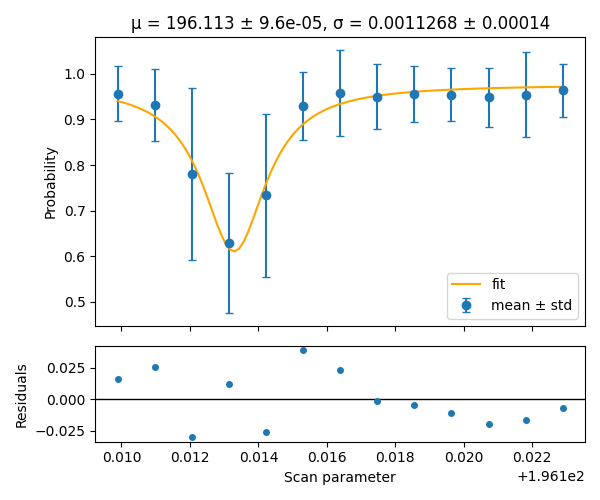

In [49]:
clk_spec = Spectroscopy()
clk_spec.fit(clk_df['df_clock_fundamental'].to_numpy(), clk_df['probability'].to_numpy())
clk_spec.plot()

In [50]:
ryd_df = dataframe_from(raw_dataset_ryd, prob_pipeline_spec)
ryd_df.head()

,run,TC_systime_sec,f_clock_fundamental_large_sideband,f_rydberg_beatlock,probability
0,525.0,1.124568e+14,196.116454,78.15,0.666667
1,1868.0,1.135112e+14,196.116491,76.40,0.727273
2,1771.0,1.134361e+14,196.116488,76.65,0.750000
3,1631.0,1.133279e+14,196.116485,78.40,0.750000
4,465.0,1.124104e+14,196.116453,80.90,0.500000


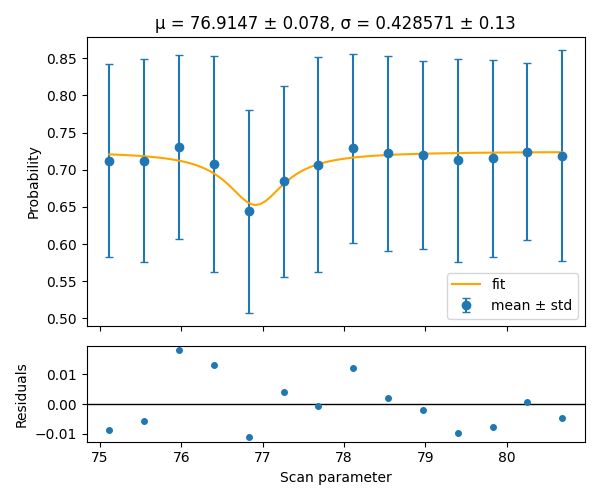

In [51]:
ryd_spec = Spectroscopy()
ryd_spec.fit(ryd_df['f_rydberg_beatlock'].to_numpy(), ryd_df['probability'].to_numpy())
ryd_spec.plot()

## Overnight spectroscopy

Here we scan the $\ket{{}^1S_0}\to\ket{{}^3P_0}$ "clock" transition over night, i.e., for many hours, to see it drift.

In [58]:
# todo

## Lifetime

Here we optimize the fluorescence imaging parameters using the $\ket{{}^1S_0}\to\ket{{}^1P_1}$ such that the loss rate is minimized.

In [44]:
raw_dataset_lft = GzipPickleDataset("/tmp/data/2025-07-25_AR")
len(raw_dataset_lft)

285

In [52]:
prob_pipeline_lft = Pipeline(steps=[
    TransformStep(PickKey("image")),
    ImageMeanStep(),
    AtomCropStep(atom_num=16),
    AtomCountStep(),
    AtomStatsStep(),
])
prob_pipeline_lft.fit(raw_dataset_lft)

In [53]:
lft_df = dataframe_from(raw_dataset_lft, prob_pipeline_lft)
lft_df.head()

,run,TC_systime_sec,df_green_cooling_bluegreen_imaging,blue_green_imaging_duration,probability
0,10.0,2.906037e+14,-12.10,0.10,0.923077
1,18.0,2.906152e+14,-12.10,0.35,1.000000
2,171.0,2.908350e+14,-12.15,0.01,1.000000
3,47.0,2.906568e+14,-12.15,0.35,1.000000
4,142.0,2.907934e+14,-12.10,0.01,1.000000


## Rabi oscillations

Here we analyze two datasets where we scan the duration of pulse driving

- the clock transition $\ket{1{}^1S_0}\to\ket{1{}^3P_0}$, and
- the rydberg transition $\ket{1{}^3P_0}\to\ket{53.3{}^1S_0}$

In [54]:
raw_dataset_rabclk = GzipPickleDataset("/tmp/data/2025-08-11_AH")
raw_dataset_rabryd = GzipPickleDataset("/tmp/data/2025-08-11_AR")

In [55]:
prob_pipeline_rab = Pipeline(steps=[
    TransformStep(PickKey("image")),
    ImageMeanStep(),
    AtomCropStep(atom_num=16),
    AtomCountStep(),
    AtomStatsStep(),
])
prob_pipeline_rab.fit(raw_dataset_rabclk)

In [56]:
rabclk_df = dataframe_from(raw_dataset_rabclk, prob_pipeline_rab)
rabclk_df.head()

,run,TC_systime_sec,dt_clock_duration,f_clock_fundamental_large_sideband,probability
0,522.0,1.144137e+13,0.000004,196.134612,1.000000
1,1865.0,1.244422e+13,0.000011,196.134646,0.416667
2,1768.0,1.237180e+13,0.000017,196.134644,0.230769
3,1628.0,1.226729e+13,0.000017,196.134640,0.416667
4,462.0,1.139655e+13,0.000004,196.134610,0.846154


In [57]:
rabryd_df = dataframe_from(raw_dataset_rabryd, prob_pipeline_rab)
rabryd_df.head()

,run,TC_systime_sec,f_clock_fundamental_large_sideband,dt_rydberg_ionization,probability
44,1039.0,1.705842e+13,196.134807,2.180000e-06,1.0
65,886.0,1.693966e+13,196.134803,2.440000e-06,0.0
129,1149.0,1.714385e+13,196.134810,3.600000e-07,0.0
131,1289.0,1.725253e+13,196.134814,2.440000e-06,0.0
199,586.0,1.670649e+13,196.134795,3.740000e-06,1.0
